In [1]:
import argparse
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Optional

In [2]:
def find_3d_dataset(h5: h5py.File, dataset_name: Optional[str]) -> h5py.Dataset:
    """Pick the dataset with shape (T, N, N). If dataset_name is given, use it."""
    if dataset_name is not None:
        if dataset_name in h5:
            ds = h5[dataset_name]
            if ds.ndim == 3:
                return ds
            else:
                raise ValueError(f"Dataset '{dataset_name}' is not 3D (ndim={ds.ndim}).")
        else:
            # allow nested paths like 'group/dset'
            try:
                ds = h5[dataset_name]
                if ds.ndim == 3:
                    return ds
                else:
                    raise ValueError(f"Dataset '{dataset_name}' is not 3D (ndim={ds.ndim}).")
            except KeyError:
                raise KeyError(f"Dataset '{dataset_name}' not found in file.")
    # Auto-discover: first 3D dataset
    def _walk(name, obj, out):
        if isinstance(obj, h5py.Dataset) and obj.ndim == 3:
            out.append(name)
    candidates = []
    h5.visititems(lambda n, o: _walk(n, o, candidates))
    if not candidates:
        raise ValueError("No 3D dataset found in HDF5 file.")
    # Pick the first one
    return h5[candidates[0]]

In [3]:
def power_iteration_spectral_radius(A: np.ndarray, max_iter: int = 100, tol: float = 1e-6, seed: int = 0) -> float:
    """
    Largest eigenvalue magnitude for a nonnegative matrix A using power iteration.
    For (3142 x 3142) with T ~ 50 this is fast enough if done once per day.
    """
    n = A.shape[0]
    rng = np.random.default_rng(seed)
    v = rng.random(n)
    v /= np.linalg.norm(v) + 1e-12
    last_val = 0.0
    for _ in range(max_iter):
        w = A @ v
        normw = np.linalg.norm(w)
        if normw < 1e-18:
            return 0.0
        v = w / normw
        # Rayleigh quotient as eigenvalue estimate
        rayleigh = float(v @ (A @ v))
        if abs(rayleigh - last_val) < tol * max(1.0, abs(rayleigh)):
            return abs(rayleigh)
        last_val = rayleigh
    return abs(last_val)

In [4]:
def frobenius_cosine(A: np.ndarray, B: np.ndarray) -> float:
    """Cosine similarity under Frobenius inner product: <A,B>_F / (||A||_F ||B||_F)."""
    num = float(np.sum(A * B))
    den = float(np.linalg.norm(A) * np.linalg.norm(B)) + 1e-18
    return num / den

def quantiles(x: np.ndarray, qs=(0.5, 0.95)) -> Tuple[float, ...]:
    return tuple(np.quantile(x, q) for q in qs)

In [3]:
import os
with h5py.File('../data/NMM_t_3142.hdf5', 'r') as f:
    dset = f['WM'][...]              # (T,N,N) numpy array

In [4]:
T, N, N2 = dset.shape

In [6]:
Mi = dset[0]

In [9]:
def is_row_stochastic(A, atol=1e-6):
    A = np.asarray(A, dtype=float)
    return np.allclose(A.sum(axis=1), 1.0, atol=atol)

def is_col_stochastic(A, atol=1e-6):
    A = np.asarray(A, dtype=float)
    return np.allclose(A.sum(axis=0), 1.0, atol=atol)

def report_stochasticity(A, name="A", atol=1e-6):
    A = np.asarray(A, dtype=float)
    row_sums = A.sum(axis=1)
    col_sums = A.sum(axis=0)
    print(f"[{name}] rows:  min={row_sums.min():.6f} max={row_sums.max():.6f} "
          f"mean={row_sums.mean():.6f} -> row_stoch={np.allclose(row_sums, 1.0, atol=atol)}")
    print(f"[{name}] cols:  min={col_sums.min():.6f} max={col_sums.max():.6f} "
          f"mean={col_sums.mean():.6f} -> col_stoch={np.allclose(col_sums, 1.0, atol=atol)}")

In [10]:
report_stochasticity(Mi, "mobility")

[mobility] rows:  min=0.343187 max=5.706882 mean=1.000000 -> row_stoch=False
[mobility] cols:  min=1.000000 max=1.000000 mean=1.000000 -> col_stoch=True


In [13]:
# Storage
total_mob = np.zeros(T)
density = np.zeros(T)
spectral = np.zeros(T)
sim_next = np.full(T, np.nan)  # similarity to t+1
out_deg_stats = np.zeros((T, 3))  # mean, median, p95
in_deg_stats  = np.zeros((T, 3))  # mean, median, p95

# For PCA on degree vectors (size 2N per day)
deg_matrix = np.zeros((T, 2 * N), dtype=np.float64)

prev = None
for t in range(T):
    # Read one slice lazily
    Wt = dset[t, :, :]

    # Basic sums and degrees
    total_mob[t] = float(Wt.sum())
    out_deg = Wt.sum(axis=1)  # leave i -> sum_j W_ij
    in_deg  = Wt.sum(axis=0)  # enter j <- sum_i W_ij

    out_mean = float(out_deg.mean())
    out_med, out_p95 = quantiles(out_deg, (0.5, 0.95))
    in_mean = float(in_deg.mean())
    in_med, in_p95 = quantiles(in_deg, (0.5, 0.95))

    out_deg_stats[t] = [out_mean, out_med, out_p95]
    in_deg_stats[t]  = [in_mean,  in_med,  in_p95]

    # Density (nonzero fraction)
    density[t] = float((Wt > 0).sum()) / float(N * N)

    # Spectral radius
    spectral[t] = power_iteration_spectral_radius(
        Wt, max_iter=80, tol=1e-6, seed=17 + t
    )

    # Day-to-day similarity
    if prev is not None:
        sim_next[t - 1] = frobenius_cosine(prev, Wt)
    prev = Wt

    # Degree vector for PCA
    deg_matrix[t, :N]   = out_deg
    deg_matrix[t, N: ]  = in_deg

# -------------------------
# Save metrics to CSV
# -------------------------
idx = np.arange(T)
df = pd.DataFrame({
"t": idx,
"total_mobility": total_mob,
"density": density,
"spectral_radius": spectral,
"similarity_to_next": sim_next
})
df[["out_mean", "out_median", "out_p95"]] = out_deg_stats
df[["in_mean", "in_median", "in_p95"]]   = in_deg_stats

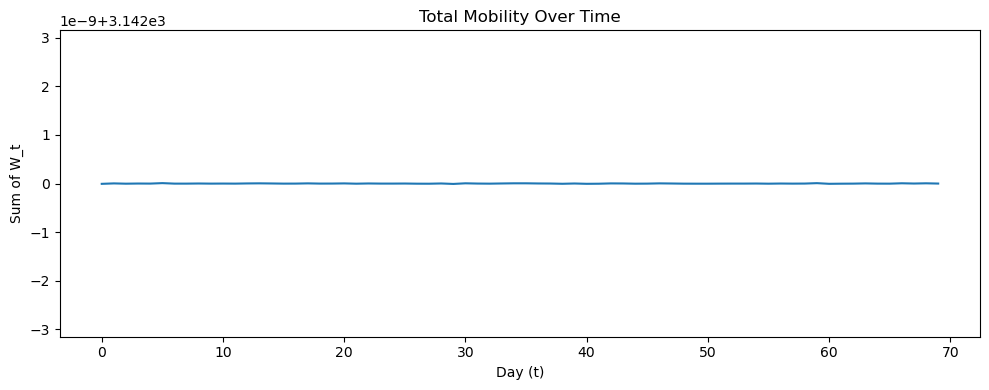

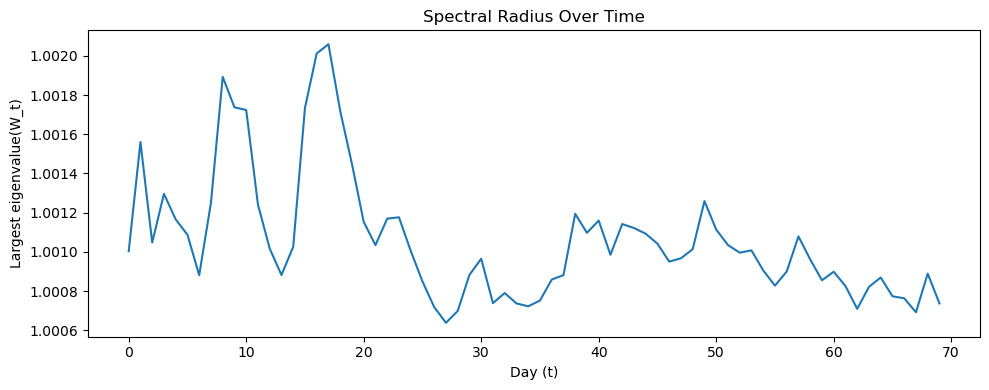

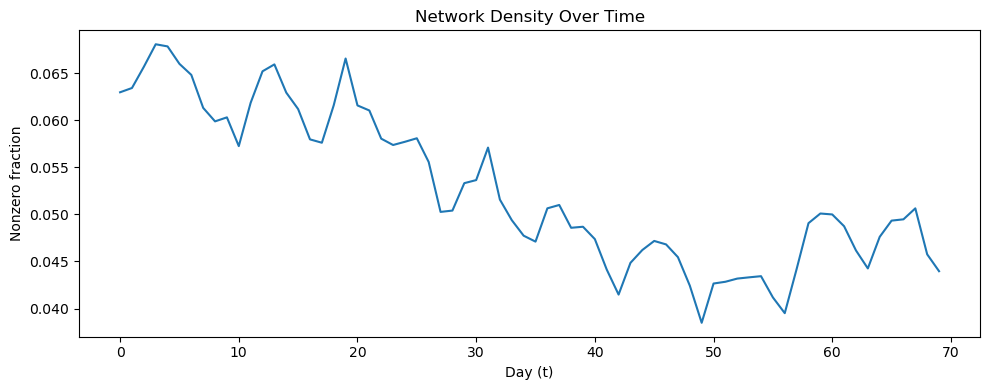

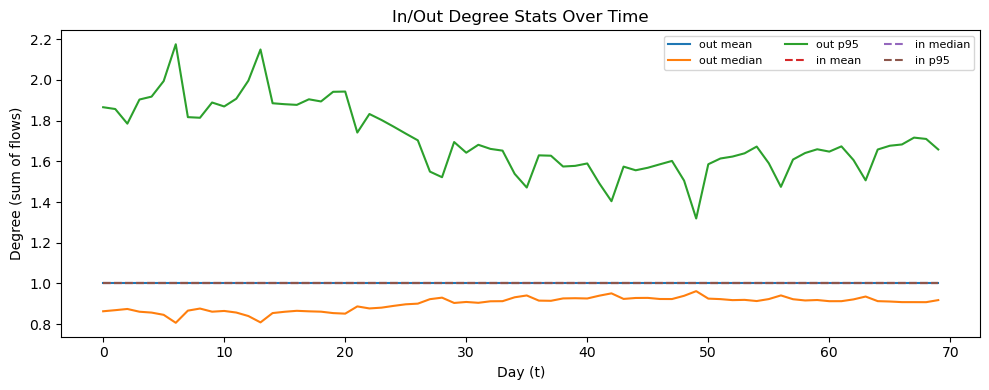

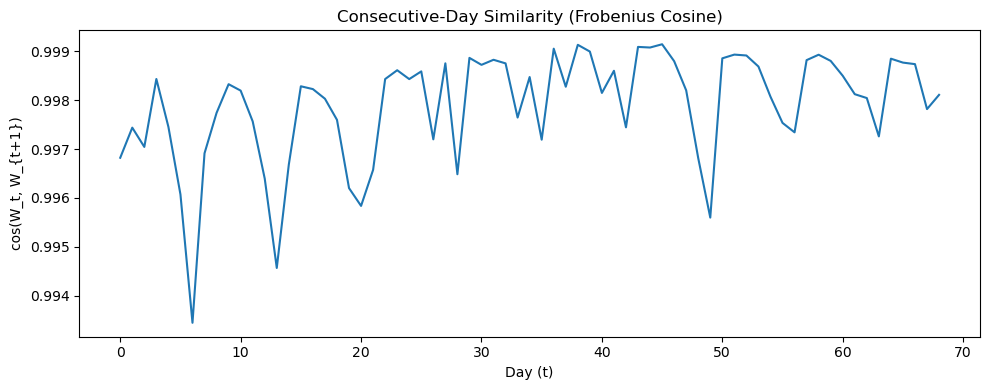

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(idx, total_mob)
plt.title("Total Mobility Over Time")
plt.xlabel("Day (t)")
plt.ylabel("Sum of W_t")
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(args.outdir, "total_mobility.png"), dpi=150)
plt.close()

plt.figure(figsize=(10, 4))
plt.plot(idx, spectral)
plt.title("Spectral Radius Over Time")
plt.xlabel("Day (t)")
plt.ylabel("Largest eigenvalue(W_t)")
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(args.outdir, "spectral_radius.png"), dpi=150)
plt.close()

plt.figure(figsize=(10, 4))
plt.plot(idx, density)
plt.title("Network Density Over Time")
plt.xlabel("Day (t)")
plt.ylabel("Nonzero fraction")
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(args.outdir, "density.png"), dpi=150)
plt.close()

plt.figure(figsize=(10, 4))
plt.plot(idx, df["out_mean"], label="out mean")
plt.plot(idx, df["out_median"], label="out median")
plt.plot(idx, df["out_p95"], label="out p95")
plt.plot(idx, df["in_mean"], label="in mean", linestyle="--")
plt.plot(idx, df["in_median"], label="in median", linestyle="--")
plt.plot(idx, df["in_p95"], label="in p95", linestyle="--")
plt.legend(ncol=3, fontsize=8)
plt.title("In/Out Degree Stats Over Time")
plt.xlabel("Day (t)")
plt.ylabel("Degree (sum of flows)")
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(args.outdir, "degree_stats.png"), dpi=150)
plt.close()

plt.figure(figsize=(10, 4))
plt.plot(idx, df["similarity_to_next"])
plt.title("Consecutive-Day Similarity (Frobenius Cosine)")
plt.xlabel("Day (t)")
plt.ylabel("cos(W_t, W_{t+1})")
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(args.outdir, "similarity.png"), dpi=150)
plt.close()

In [23]:
np.sum(Wt[:,0])

1.0